# PROJECT 1 - MLP ANN

# INTRODUCTION

## Objectives

- Select two datasets, one for classification and one for regression
- Separate into training/validation/test
- Train MLP models for the two problems, using the SGB algorithm
- Use several models and select the most accurate one
     - 5 topologies varying the number of hidden layers
         - no hidden layers
         - 1, 3, 4, and 5 hidden layers
- Evaluate the impact of Momentum (0.01, 0.1, 0.2, 0.5, 1.0)
- Evaluate the impact of using regularization (eg L2) (0.01, 0.05, 0.1, 0.5, 1.0)
- Show the error decaying for the training set, and for the validation set
- Graphically illustrate the evolution of training (training/validation)

## Datasets used

Two available datasets from the scikit-learn library were chosen, one for classification and the other for regression:

### DIGITS (classification)

- Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

UCI ML hand-written digits dataset for classification, consisting of 1797 digit images, 8x8 pixels, containing handwritten digits 0 to 9:

     Classes: 10
     Samples per class: ~180
     Total samples: 1797
     Dimensionality: 64
     Features: integers 0-16


### BOSTON (regression)

- Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

Boston housing prices is a dataset for regression, composed of:

    Samples total: 506
    Dimensionality: 13
    Features: real, positive
    Targets: real 5. - 50.

## Training/validation/test sets

The original datasets were initially divided into two sets, in the proportion of 80% for training&validation and 20% for testing. Then the training&validation set was divided in the proportion of 80% for training and 20% for validation, resulting in 3 sets:

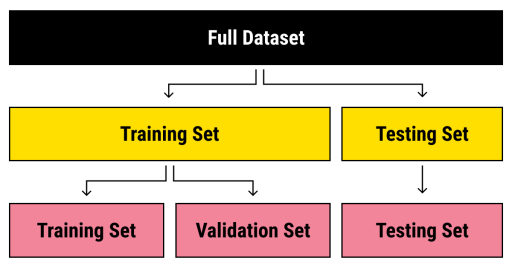

## MLP ANN

Two problems were trained using MLP (Multi-Layer Perceptron) models. MLP network example:

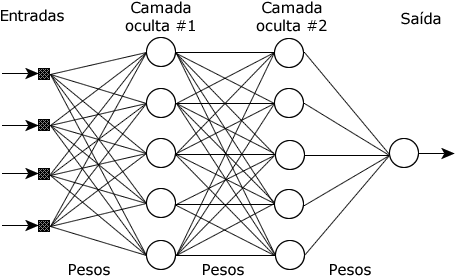

## SGD Algorithm

In all training, the SGD (Stochastic Gradient Descent) algorithm was used, which is an iterative function optimization method. Example SGD algorithm:

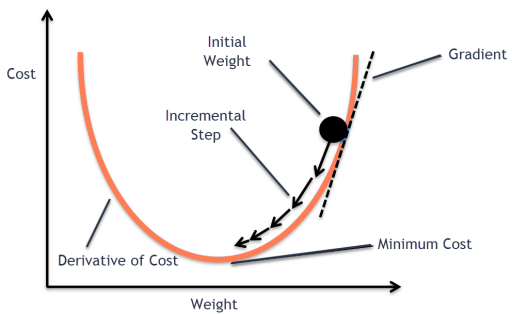

## Topology

Several topologies were used, with and without hidden layers:

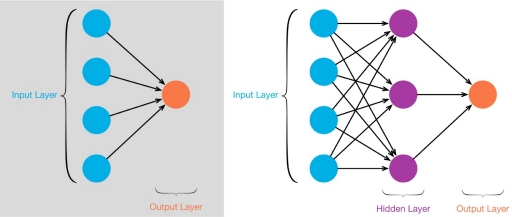

- no hidden layers
- 1, 3, 4, and 5 hidden layers

It was considered that the input layer, represented in the drawing above, just provides the data without changing it, it just moves the data. The output layer and the hidden layers have functions that perform calculations with the input data, and the results appear in the neuron outputs.

## Momentum

When using the gradient descent optimization algorithm, it is possible that the surface that the equation describes is complex and has many local minima, making it difficult to obtain the global minimum. In this case one can use the momentum term to increase the size of the steps taken towards the minimum, thus trying to skip the local minima:

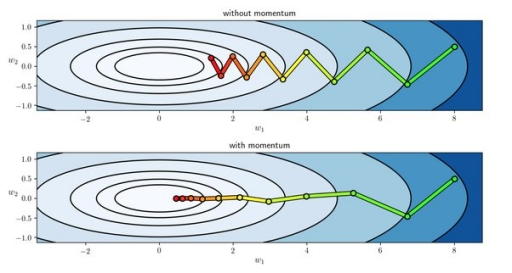

## Regularization

Regularization can be used to avoid overfitting the data, establishing a limit for the weights, avoiding the saturation of synapses:

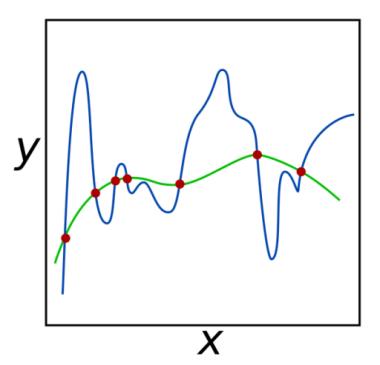

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import random as python_random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

To get [Reproducible Results](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development):

In [2]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

## Helper functions for generating graphs

In [3]:
def plot_clas_trai_eval(histories, title):
    plt.figure(dpi=100)
    plt.title(title)
    for history, j in zip(histories, range(len(histories))):
        plt.plot(history.epoch, history.history["accuracy"], label="Training")
        plt.plot(history.epoch,
                 history.history["val_accuracy"],
                 label="Validation")
    plt.ylabel("Root mean square error")
    plt.xlabel("Ephocs")
    plt.legend()
    plt.show()

In [4]:
def plot_classification(histories, eixo_y):
    plt.figure(dpi=100)
    for history, j in zip(histories, range(len(histories))):
        plt.plot(history.epoch,
                 history.history["val_accuracy"],
                 label=f"{eixo_y[j]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Ephocs")
    plt.legend()
    plt.show()

In [5]:
def plot_regr_trai_eval(histories, title):
    plt.figure(dpi=100)
    plt.title(title)
    for history, j in zip(histories, range(len(histories))):
        plt.plot(history.epoch, history.history["loss"], label="Training")
        plt.plot(history.epoch, history.history["val_loss"], label="Validation")
    plt.ylabel("Root mean square error")
    plt.xlabel("Ephocs")
    plt.legend()
    plt.show()

In [6]:
def plot_regression(histories, eixo_y):
    plt.figure(dpi=100)
    for history, j in zip(histories, range(len(histories))):
        plt.plot(history.epoch,
                 history.history["val_loss"],
                 label=f"{eixo_y[j]}")
    plt.ylabel("Root mean square error")
    plt.xlabel("Ephocs")
    plt.legend()
    plt.show()

---

# CLASSIFICATION

For the classification problem, the DIGITS dataset and 5 topologies were selected:
- no hidden layers
- 1, 3, 4, and 5 hidden layers

In [7]:
from sklearn.datasets import load_digits

In [8]:
digits = load_digits(as_frame=True)

Shows what the dataset looks like:

In [9]:
digits.data.head(n=3)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0


To carry out the training and Validation of the learning of the MLP network, it is necessary to create and divide the dataset into two groups, Training&Validation (80%) and Test (20%). The Training&Validation group will be further subdivided by Keras `fit` function.

The division operation is done with the aid of the `scikit-learn` library:

In [10]:
X_train, X_test, y_trainnu, y_testnu = train_test_split(digits.data,
                                                        digits.target,
                                                        test_size=0.20,
                                                        random_state=123)

In [11]:
y_train = keras.utils.to_categorical(y_trainnu)
y_test = keras.utils.to_categorical(y_testnu)

Shows the shapes of sets:

In [148]:
X_train.shape

(404, 12)

In [13]:
y_train.shape

(1437, 10)

## No hidden layer

Define the topology:

In [14]:
inputs = keras.Input(shape=(64,), name="digits")
outputs = layers.Dense(10, activation="sigmoid", name="predictions")(inputs)

model = keras.Model(inputs=inputs, outputs=outputs)

2022-07-14 13:59:31.671963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 13:59:32.256167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1719 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


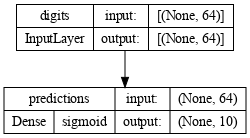

In [16]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=72)

Define optimization, loss function, and metrics:

In [15]:
model.compile(optimizer="sgd",     # Gradient descent (with momentum) optimizer
              loss="mse",          # Mean Squared Error
              metrics="accuracy")  # Calculates how often predictions equal labels

Training is done with 300 Ephocs, and also divides the dataset into Training (80%) and Validation (20%). The Keras model sets aside 20% of the data for training, does not train on it, and evaluates the loss and any model metrics on that data at the end of each epoch. Validation data is selected from the last samples in the given x and y data:

In [18]:
history = [model.fit(X_train, y_train, epochs=300,
                     validation_split=0.2, verbose=0)]
histories = history

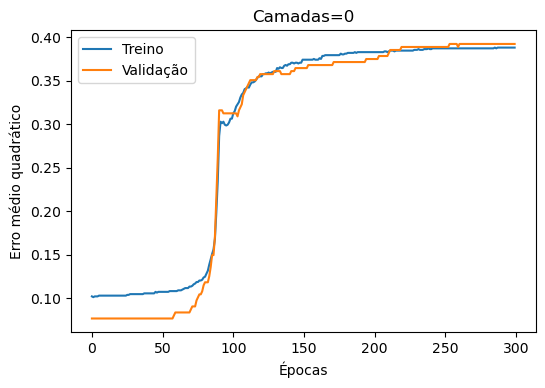

In [19]:
plot_clas_trai_eval(history, "Layers=0")

## Uma camada oculta

In [20]:
inputs = keras.Input(shape=(64,), name="digits")
x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)  # camada oculta 1
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

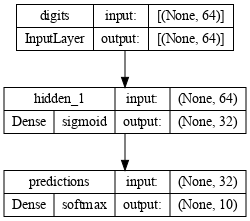

In [21]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=72)

In [22]:
model.compile(optimizer="sgd",     # Gradient descent (with momentum) optimizer
              loss="mse",          # Mean Squared Error
              metrics="accuracy")  # Calculates how often predictions equal labels

In [23]:
history = [model.fit(X_train, y_train, epochs=300,
                     validation_split=0.2, verbose=0)]
histories = histories + history

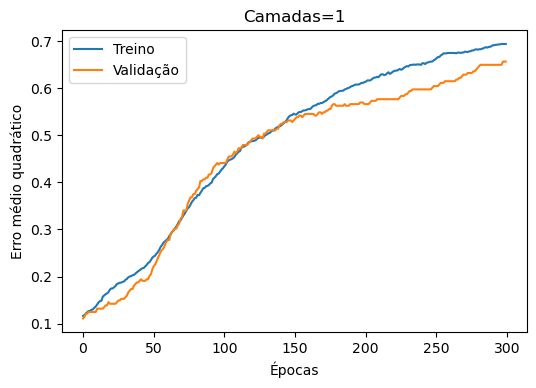

In [24]:
plot_clas_trai_eval(history, "Layers=1")

## Three Hidden Layers

In [25]:
inputs = keras.Input(shape=(64,), name="digits")
x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(32, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(32, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

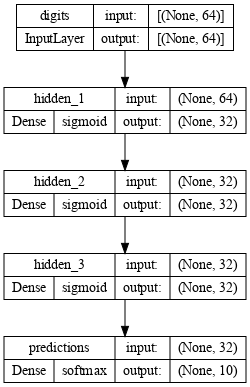

In [26]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=72)

In [27]:
model.compile(optimizer="sgd",     # Gradient descent (with momentum) optimizer
              loss="mse",          # Mean Squared Error
              metrics="accuracy")  # Calculates how often predictions equal labels

In [28]:
history = [model.fit(X_train, y_train, epochs=300,
                     validation_split=0.2, verbose=0)]
histories = histories + history

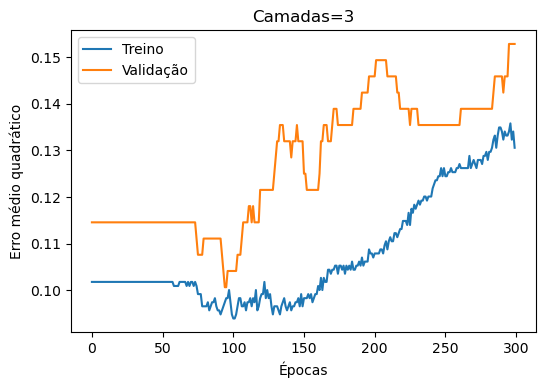

In [29]:
plot_clas_trai_eval(history, "Layers=3")

## Four Hidden Layers

In [30]:
inputs = keras.Input(shape=(64,), name="digits")
x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(32, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(32, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
x = layers.Dense(32, activation="sigmoid", name="hidden_4")(x)  #camada oculta 4
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

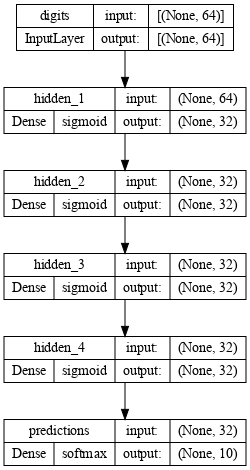

In [31]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=72)

In [32]:
model.compile(optimizer="sgd",     # Gradient descent (with momentum) optimizer
              loss="mse",          # Mean Squared Error
              metrics="accuracy")  # Calculates how often predictions equal labels

In [34]:
history = [model.fit(X_train, y_train, epochs=300,
                     validation_split=0.2, verbose=0)]
histories = histories + history

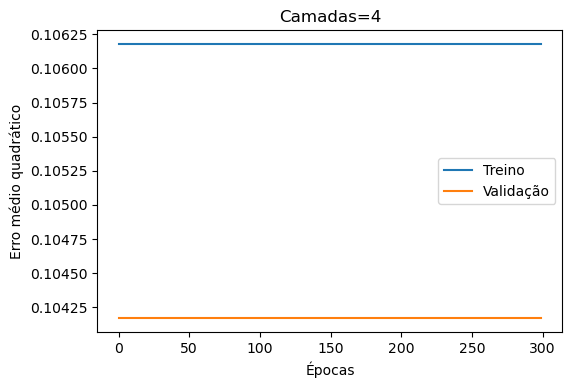

In [35]:
plot_clas_trai_eval(history, "Layers=4")

## Five Hidden Layers

In [36]:
inputs = keras.Input(shape=(64,), name="digits")
x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(32, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(32, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
x = layers.Dense(32, activation="sigmoid", name="hidden_4")(x)  #camada oculta 4
x = layers.Dense(32, activation="sigmoid", name="hidden_5")(x)  #camada oculta 5
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

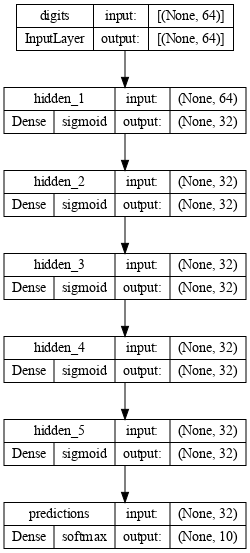

In [37]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=72)

In [38]:
model.compile(optimizer="sgd",     # Gradient descent (with momentum) optimizer
              loss="mse",          # Mean Squared Error
              metrics="accuracy")  # Calculates how often predictions equal labels

In [40]:
history = [model.fit(X_train, y_train, epochs=300,
                     validation_split=0.2, verbose=0)]
histories = histories + history

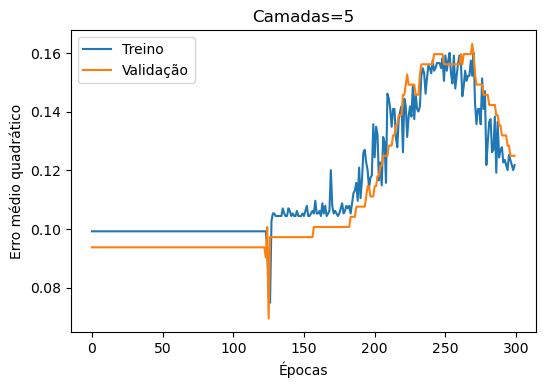

In [41]:
plot_clas_trai_eval(history, "Layers=5")

## Selection

Accuracy variation during Validation, for different amounts of Layers:

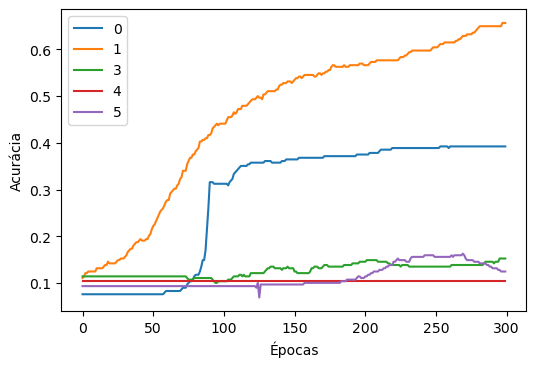

In [42]:
plot_classification(histories, [0, 1, 3, 4, 5])

1 layer was selected because it has the highest Accuracy

## Evaluation using test data

- a hidden layer

In [43]:
inputs = keras.Input(shape=(64,), name="digits")
x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [45]:
model.compile(
    optimizer="sgd",     # Gradient descent (with momentum) optimizer
    loss="mse",          # Mean Squared Error
    metrics="accuracy")  # Calculates how often predictions equal labels

In [46]:
history = [
    model.fit(X_train, y_train, epochs=300, validation_split=0.2, verbose=0)
]

The `evaluate` function returns the loss value and metric values for the model in test mode.

In [47]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, y_test)
print("Evaluate on test data:")
print("test loss, test acc:", results)

12/12 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.5722
Evaluate on test data:
test loss, test acc: [0.06529810279607773, 0.5722222328186035]


## Assessing the impact of using Momentum

In [48]:
def momentum_aval(momentum):
    inputs = keras.Input(shape=(64,), name="digits")
    x = layers.Dense(32, activation="sigmoid", name="hidden_1")(inputs)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        # Gradient descent (with momentum) optimizer
        optimizer=keras.optimizers.SGD(momentum=momentum),
        # Mean Squared Error
        loss="mse",
        # Calculates how often predictions equal labels
        metrics="accuracy")
    # returns fit history and fitted model
    return model.fit(X_train,
                     y_train,
                     epochs=200,
                     verbose=0,
                     validation_split=.02)

## Momentum = 0.01

In [50]:
history = [momentum_aval(0.01)]

In [51]:
histories = history

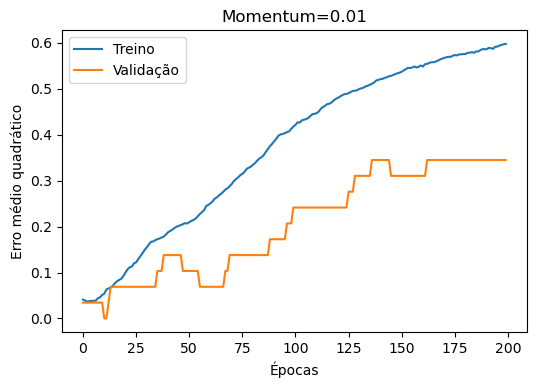

In [52]:
plot_clas_trai_eval(history, "Momentum=0.01")

## Momentum = 0.1

In [54]:
history = [momentum_aval(.1)]

In [55]:
histories = histories + history

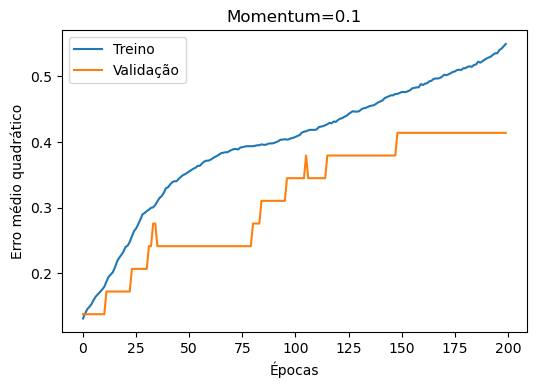

In [56]:
plot_clas_trai_eval(history, "Momentum=0.1")

## Momentum = 0.2

In [58]:
history = [momentum_aval(.2)]

In [59]:
histories = histories + history

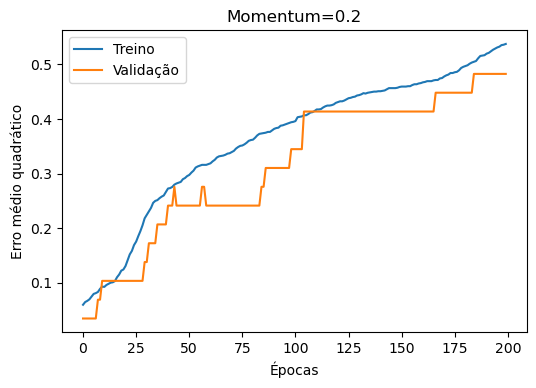

In [60]:
plot_clas_trai_eval(history, "Momentum=0.2")

## Momentum = 0.5

In [62]:
history = [momentum_aval(.5)]

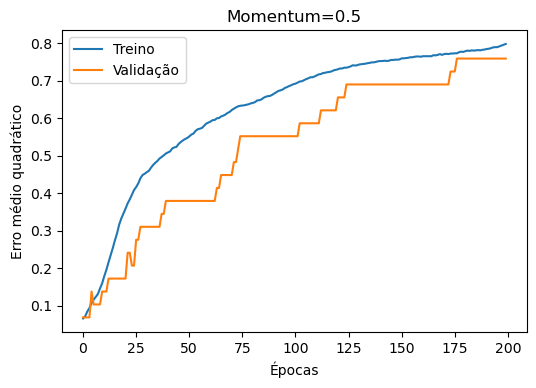

In [63]:
plot_clas_trai_eval(history, "Momentum=0.5")

In [64]:
histories = histories + history

## Momentum = 1.0

In [66]:
history = [momentum_aval(1.0)]

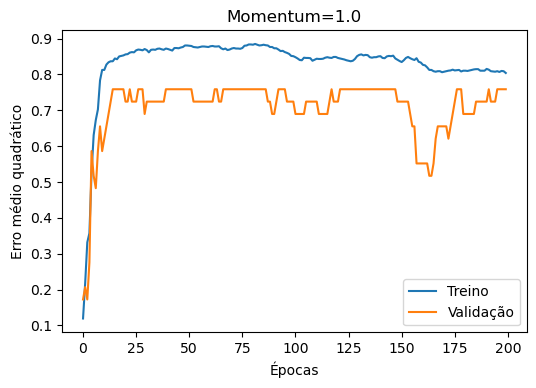

In [67]:
plot_clas_trai_eval(history, "Momentum=1.0")

In [68]:
histories = histories + history

## Selection

Loss variation during Validation, for different amounts of Layers:

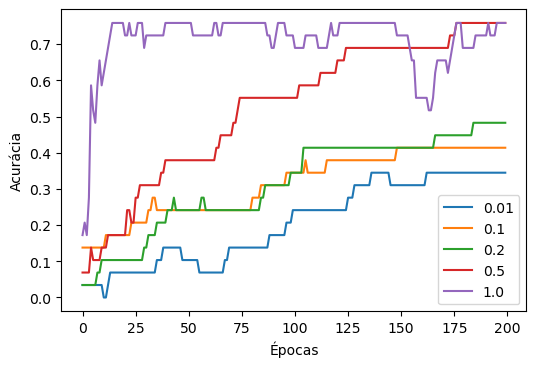

In [69]:
plot_classification(histories, [0.01, 0.1, 0.2, 0.5, 1.0])

Selected the option with momentum=0.01 as it achieves the highest Accuracy in the least amount of Ephocs.

## Evaluation of the impact of using L2 regularization

In [70]:
def regul_aval(rl2):
    inputs = keras.Input(shape=(64,), name="digits")
    x = layers.Dense(32,
                     activation="sigmoid",
                     name="hidden_1",
                     kernel_regularizer=keras.regularizers.l2(rl2))(inputs)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        # Gradient descent (with momentum) optimizer
        optimizer="sgd",
        # Mean Squared Error
        loss="mse",
        # Calculates how often predictions equal labels
        metrics="accuracy")
    # returns fit history and fitted model
    return model.fit(X_train,
                     y_train,
                     epochs=200,
                     verbose=0,
                     validation_split=.02)

## Regularization = 0.01

In [72]:
history = [regul_aval(0.01)]

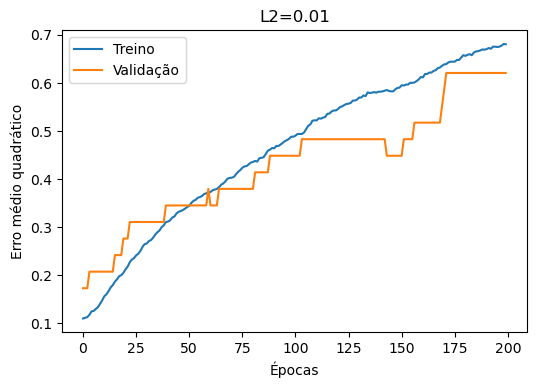

In [73]:
plot_clas_trai_eval(history, "L2=0.01")

In [74]:
histories = history

## Regularization = 0.05

In [76]:
history = [regul_aval(0.05)]

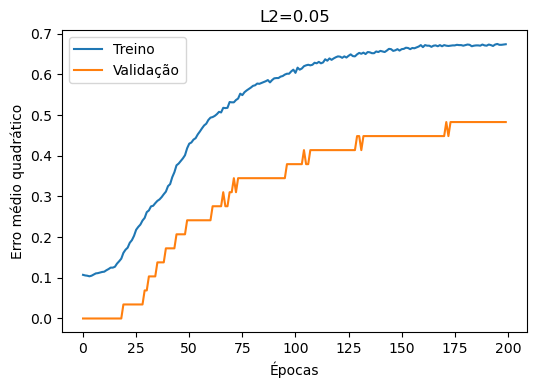

In [77]:
plot_clas_trai_eval(history, "L2=0.05")

In [78]:
histories = histories + history

## Regularization = 0.1

In [80]:
history = [regul_aval(0.1)]

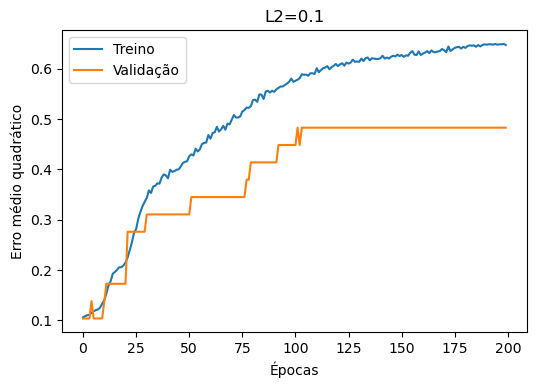

In [81]:
plot_clas_trai_eval(history, "L2=0.1")

In [82]:
histories = histories + history

## Regularization = 0.5

In [84]:
history = [regul_aval(0.5)]

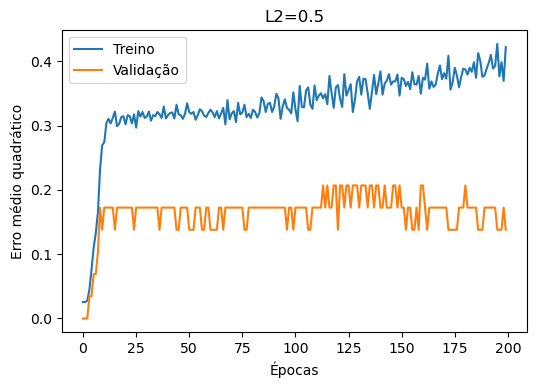

In [85]:
plot_clas_trai_eval(history, "L2=0.5")

In [86]:
histories = histories + history

## Regularization = 1.0

In [88]:
history = [regul_aval(1.0)]

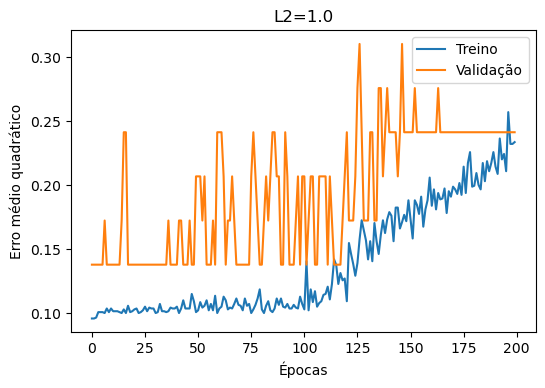

In [89]:
plot_clas_trai_eval(history, "L2=1.0")

In [90]:
histories = histories + history

## Selection

Accuracy variation during Validation, for different L2:

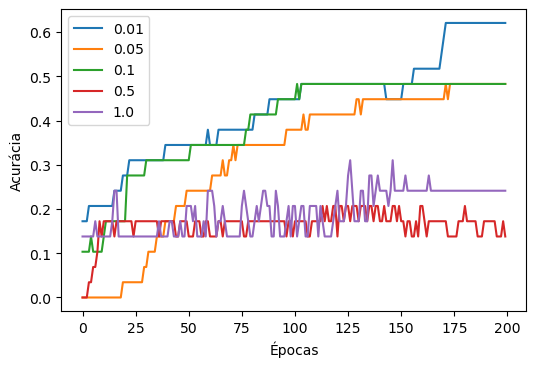

In [91]:
plot_classification(histories, [0.01, 0.05, 0.1, 0.5, 1.0])

Selected the option L2=0.01 because it has the highest Accuracy.

---

# REGRESSION

Many of the comments made in the previous section for the classification problem are applicable in this section and for brevity will not be repeated:

In [31]:
from sklearn.datasets import load_boston

In [32]:
X_boston, y_boston = load_boston(return_X_y=True)

In [33]:
X_boston.shape

(506, 13)

In [34]:
X = pd.DataFrame(X_boston,
                 columns=[
                     'Crime Rate', 'Residential Land Zones',
                     'Non-retail Business Acres', 'Charles River tract bounds',
                     'N.O. Concentration', '# of Rooms', 'Age',
                     'Distance to Employment', 'Highway Accessibility',
                     'Property Tax Rate', 'Pupil Teacher Ratio', 'B',
                     '% Lower Income'
                 ])

In [35]:
X.drop("B", axis=1, inplace=True)

In [36]:
y = pd.DataFrame(y_boston, columns=['Median Home Value'])

In [37]:
X.shape

(506, 12)

In [38]:
X.head(n=3)

,Crime Rate,Residential Land Zones,Non-retail Business Acres,Charles River tract bounds,N.O. Concentration,# of Rooms,Age,Distance to Employment,Highway Accessibility,Property Tax Rate,Pupil Teacher Ratio,% Lower Income
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03


In [39]:
y.head(n=3)

,Median Home Value
0,24.0
1,21.6
2,34.7


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

The MinMaxScaler class transforms features by scaling each feature to a certain range, and is often used as an alternative to zero-mean, unit variance scaling. Methods:
- `fit(X[, y])` Computes the minimum and maximum to use for further scaling.
- `transform(X)` Scale features of X according to `feature_range` (default=(0, 1)).

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

X_train before transformation:

In [41]:
X_train.head(n=3)

,Crime Rate,Residential Land Zones,Non-retail Business Acres,Charles River tract bounds,N.O. Concentration,# of Rooms,Age,Distance to Employment,Highway Accessibility,Property Tax Rate,Pupil Teacher Ratio,% Lower Income
172,0.13914,0.0,4.05,0.0,0.510,5.572,88.5,2.5961,5.0,296.0,16.6,14.69
429,9.33889,0.0,18.10,0.0,0.679,6.380,95.6,1.9682,24.0,666.0,20.2,24.08
441,9.72418,0.0,18.10,0.0,0.740,6.406,97.2,2.0651,24.0,666.0,20.2,19.52


Transformation :

In [45]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train after transformation :

In [44]:
print(scaler.transform(X_train))

[[0.00180639 0.         0.13159824 ... 0.20801527 0.42553191 0.35761589]
 [0.12692577 0.         0.64662757 ... 0.91412214 0.80851064 0.61672185]
 [0.13216583 0.         0.64662757 ... 0.91412214 0.80851064 0.49089404]
 ...
 [0.25574932 0.         0.64662757 ... 0.91412214 0.80851064 0.90066225]
 [0.0018321  0.         0.49340176 ... 0.19465649 0.36170213 0.38934879]
 [0.11948953 0.         0.64662757 ... 0.91412214 0.80851064 0.42577263]]


In [ ]:
X_train.head(n=3)

In [47]:
X_train.shape

(404, 12)

In [48]:
y_train.shape

(404, 1)

## No hidden layer

In [114]:
inputs = keras.Input(shape=(12,), name="house")
outputs = layers.Dense(1, name="predictions")(inputs)

model2 = keras.Model(inputs=inputs, outputs=outputs)

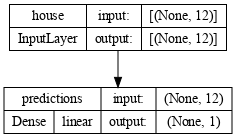

In [115]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True, dpi=72)

In [116]:
model2.compile(
    optimizer="sgd",  # Gradient descent (with momentum) optimizer
    loss="mse")  # Mean Squared Error

In [117]:
history = [model2.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

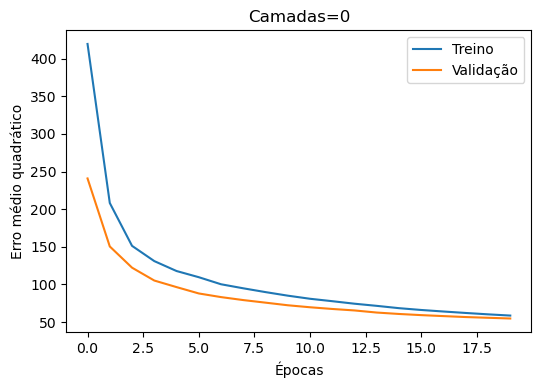

In [118]:
plot_regr_trai_eval(history, "Layers=0")

In [119]:
histories = history

## One hidden layer

In [120]:
inputs = keras.Input(shape=(12,), name="house")
x = layers.Dense(5, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
outputs = layers.Dense(1, name="predictions")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)

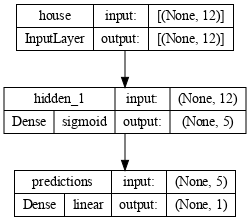

In [121]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True, dpi=72)

In [122]:
model2.compile(optimizer="sgd",  # Gradient descent (with momentum) optimizer
              loss="mse")  # Mean Squared Error

In [123]:
history = [model2.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

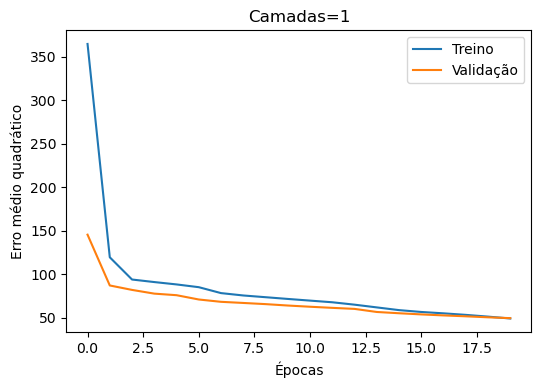

In [124]:
plot_regr_trai_eval(history, "Layers=1")

In [125]:
histories = histories + history

## Three hidden layers

In [126]:
inputs = keras.Input(shape=(12,), name="house")
x = layers.Dense(5, activation="sigmoid",name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(5, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(5, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
outputs = layers.Dense(1, name="predictions")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)

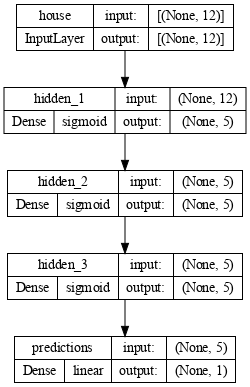

In [127]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True, dpi=72)

In [128]:
model2.compile(
    optimizer="sgd",  # Gradient descent (with momentum) optimizer
    loss="mse")  # Mean Squared Error

In [129]:
history = [model2.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

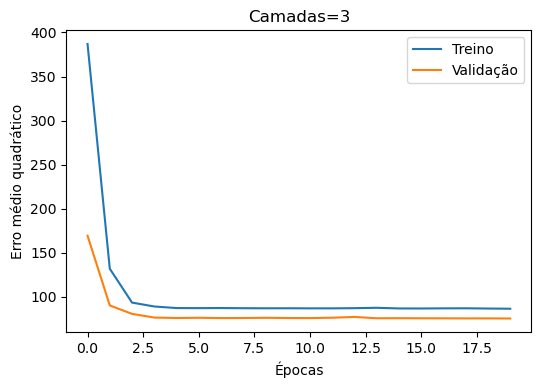

In [130]:
plot_regr_trai_eval(history, "Layers=3")

In [131]:
histories = histories + history

## Four hidden layers

In [132]:
inputs = keras.Input(shape=(12,), name="house")
x = layers.Dense(5, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(5, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(5, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
x = layers.Dense(5, activation="sigmoid", name="hidden_4")(x)  #camada oculta 4
outputs = layers.Dense(1, name="predictions")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)

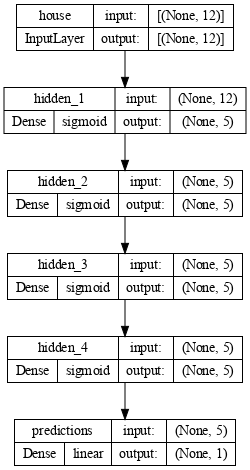

In [133]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True, dpi=72)

In [134]:
model2.compile(
    optimizer="sgd",  # Gradient descent (with momentum) optimizer
    loss="mse")  # Mean Squared Error

In [135]:
history = [model2.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

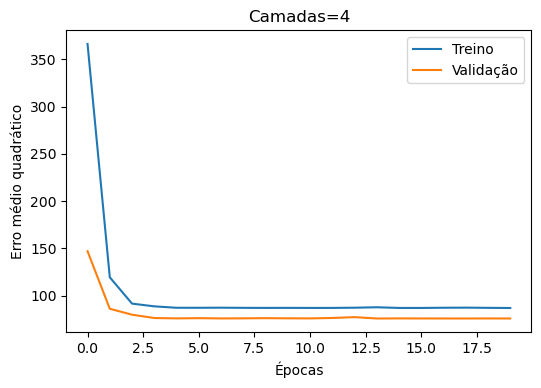

In [136]:
plot_regr_trai_eval(history, "Layers=4")

In [137]:
histories = histories + history

## Five hidden layers

In [138]:
inputs = keras.Input(shape=(12,), name="house")
x = layers.Dense(5, activation="sigmoid", name="hidden_1")(inputs)  #camada oculta 1
x = layers.Dense(5, activation="sigmoid", name="hidden_2")(x)  #camada oculta 2
x = layers.Dense(5, activation="sigmoid", name="hidden_3")(x)  #camada oculta 3
x = layers.Dense(5, activation="sigmoid", name="hidden_4")(x)  #camada oculta 4
x = layers.Dense(5, activation="sigmoid", name="hidden_5")(x)  #camada oculta 5
outputs = layers.Dense(1, name="predictions")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)

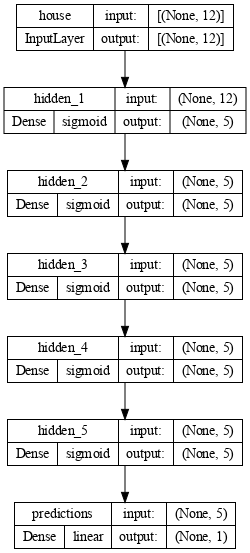

In [139]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True, dpi=72)

In [140]:
model2.compile(
    optimizer="sgd",  # Gradient descent (with momentum) optimizer
    loss="mse")  # Mean Squared Error

In [141]:
history = [model2.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

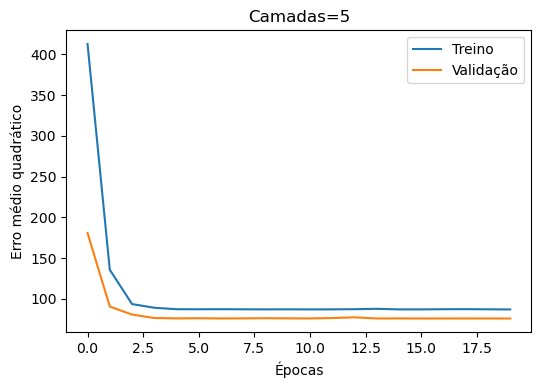

In [142]:
plot_regr_trai_eval(history, "Layers=5")

In [143]:
histories = histories + history

## Selection

Loss variation during Validation, for different amounts of Layers:

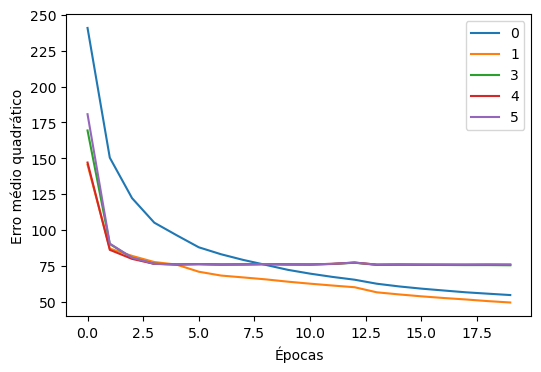

In [144]:
plot_regression(histories, [0, 1, 3, 4, 5])

The option with 1 hidden layer was selected because it has the lowest Root mean square error, close to 50.

## Evaluation using test data

- a hidden layer

In [18]:
inputs = keras.Input(shape=(12,), name="house")
x = layers.Dense(5, activation="sigmoid", name="hidden_1")(inputs)  # camada oculta 1
outputs = layers.Dense(1, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2022-07-13 13:59:50.867976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 13:59:56.183846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1949 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [20]:
model.compile(
    optimizer="sgd",  # Gradient descent (with momentum) optimizer
    loss="mse")       # Mean Squared Error

In [22]:
history = [model.fit(X_train, y_train, epochs=20,
                     validation_split=0.2, verbose=0)]

In [23]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, y_test)
print("Evaluate on test data:")
print("test loss, test acc:", results)

4/4 [==============================] - 0s 3ms/step - loss: 46.5655
Evaluate on test data:
test loss, test acc: 46.565452575683594


## Assessing the impact of using Momentum

- A hidden layer.

In [116]:
def momentum_aval(momentum):
    inputs = keras.Input(shape=(12,), name="house")
    x = layers.Dense(5, activation="sigmoid", name="hidden_1")(inputs)
    outputs = layers.Dense(1, name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        # Gradient descent (with momentum) optimizer
        optimizer=keras.optimizers.SGD(momentum=momentum),
        # Mean Squared Error
        loss="mse",
        # Calculates how often predictions equal labels
        metrics="accuracy")
    # returns fit history and fitted model
    return model.fit(X_train,
                     y_train,
                     epochs=20,
                     validation_split=0.2,
                     verbose=0)

## Momentum = 0.01

In [138]:
history = [momentum_aval(0.01)]

In [139]:
histories = history

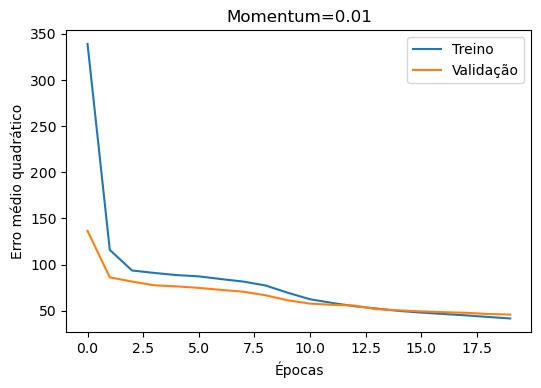

In [120]:
plot_regr_trai_eval(history, "Momentum=0.01")

## Momentum = 0.1

In [140]:
history = [momentum_aval(0.1)]

In [141]:
histories = histories + history

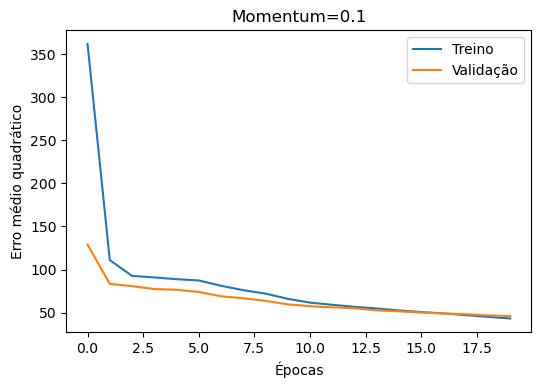

In [124]:
plot_regr_trai_eval(history, "Momentum=0.1")

## Momentum = 0.2

In [142]:
history = [momentum_aval(0.2)]

In [143]:
histories = histories + history

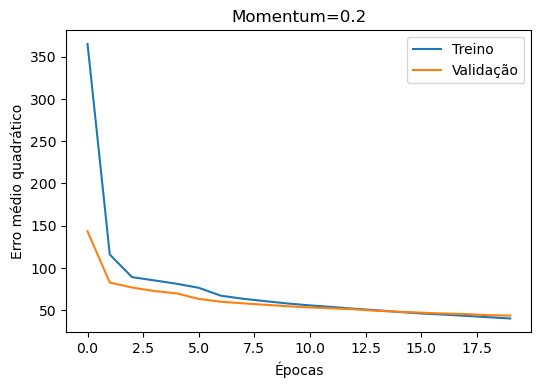

In [127]:
plot_regr_trai_eval(history, "Momentum=0.2")

## Momentum = 0.5

In [144]:
history = [momentum_aval(0.5)]

In [145]:
histories = histories + history

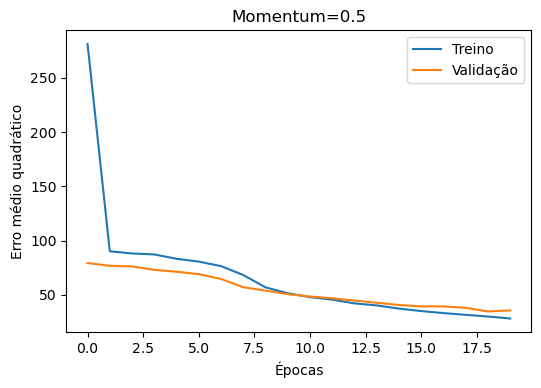

In [131]:
plot_regr_trai_eval(history, "Momentum=0.5")

## Momentum = 1.0

In [146]:
history = [momentum_aval(1.0)]

In [147]:
histories = histories + history

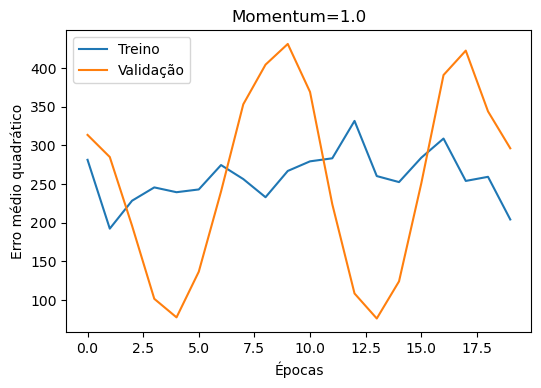

In [135]:
plot_regr_trai_eval(history, "Momentum=1.0")

## Selection

Loss variation during Validation, for several Momentum:

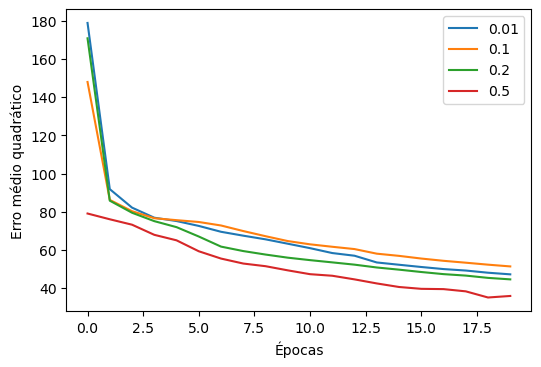

In [148]:
plot_regression(histories, [0.01, 0.1, 0.2, 0.5, 1.0])

The best momentum is 0.5, with the lowest Root mean square error.

## Evaluation of the impact of using L2 regularization

In [151]:
def regul_aval(rl2):
    inputs = keras.Input(shape=(12,), name="house")
    x = layers.Dense(5,
                     activation="sigmoid",
                     name="hidden_1",
                     kernel_regularizer=keras.regularizers.l2(rl2))(inputs)
    outputs = layers.Dense(1, name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        # Gradient descent (with momentum) optimizer
        optimizer="sgd",
        # Mean Squared Error
        loss="mse",
        # Calculates how often predictions equal labels
        metrics="accuracy")
    # returns fit history and fitted model
    return model.fit(X_train,
                     y_train,
                     epochs=20,
                     validation_split=0.2,
                     verbose=0)

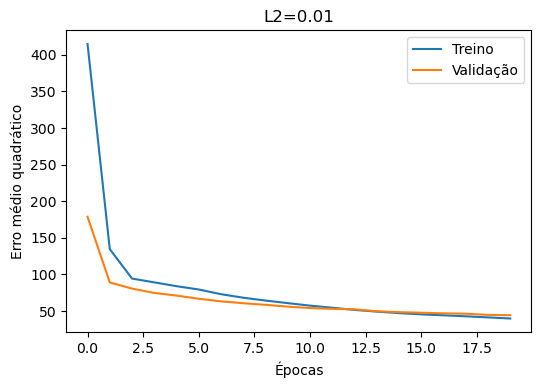

In [154]:
history = [regul_aval(0.01)]
histories = history
plot_regr_trai_eval(history, "L2=0.01")

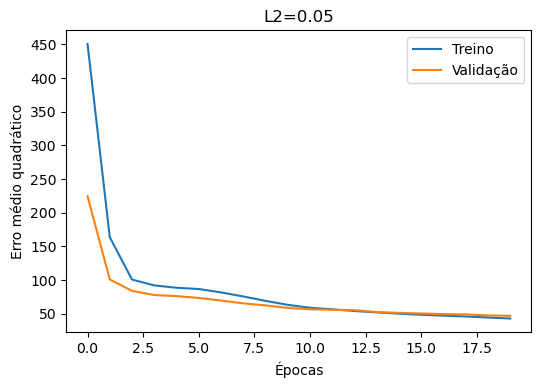

In [155]:
history = [regul_aval(0.05)]
histories = histories + history
plot_regr_trai_eval(history, "L2=0.05")

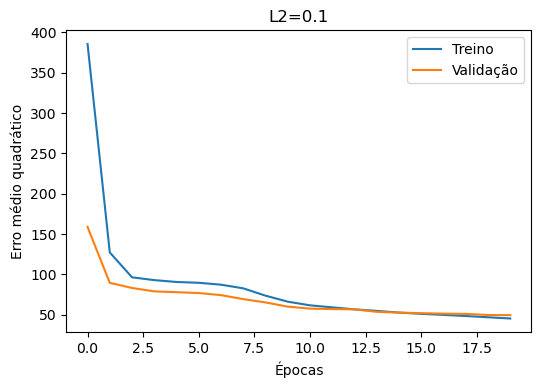

In [156]:
history = [regul_aval(0.1)]
histories = histories + history
plot_regr_trai_eval(history, "L2=0.1")

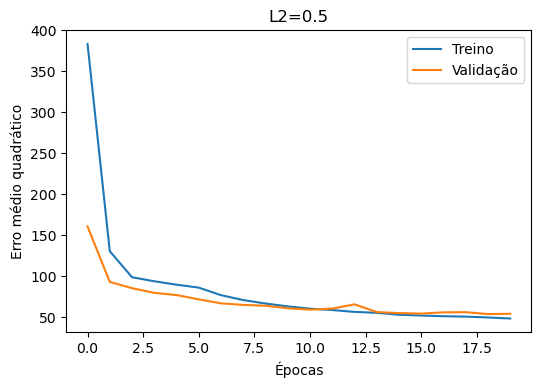

In [157]:
history = [regul_aval(0.5)]
histories = histories + history
plot_regr_trai_eval(history, "L2=0.5")

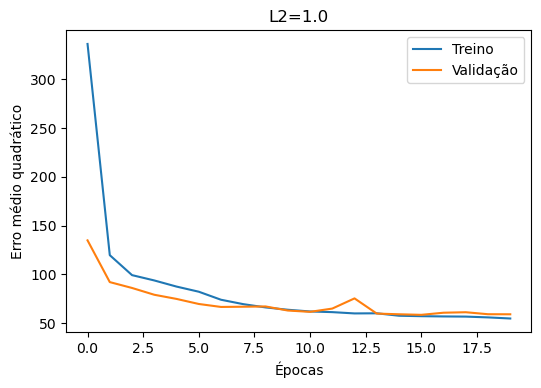

In [158]:
history = [regul_aval(1.0)]
histories = histories + history
plot_regr_trai_eval(history, "L2=1.0")

## Selection

Loss variation during Validation, for several L2:

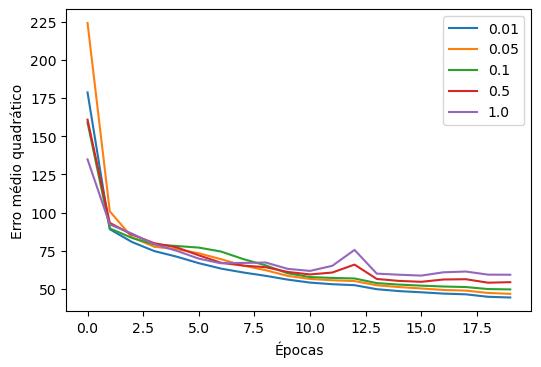

In [168]:
plot_regression(histories, [0.01, 0.05, 0.1, 0.5, 1.0])

In [ ]:
O melhor L2 é 0.01, que leva ao menor Root mean square error.

# REFERENCES

- https://www.tensorflow.org/guide/keras/train_and_evaluate
- https://www.thepythonacademy.com/post/predicting-house-prices-using-a-deep-neural-network-case-with-the-boston-dataset
- http://www.stodolkiewicz.com/2020/01/04/tensorflow-2-regression-on-boston-housing-dataset/
- https://scikit-learn.org
- https://www.kaggle.com/code/escofresco/boston-housing

# APPENDIX

## Versions

In [109]:
from platform import python_version
print(python_version())

3.9.13


In [107]:
print(tf.__version__)

2.9.1


In [116]:
import matplotlib
print(matplotlib.__version__)

3.3.2


In [118]:
print(pd.__version__)

1.4.2


In [119]:
import sklearn
print(sklearn.__version__)

0.23.2


In [4]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]